<h1>Classifcation of Aerial Images</h1>
In this noteboook, I have trained a convolutional neural network to classify satellite images into 7 classes.<br>
The dataset used for training consists of 80 images per class. 

In [ ]:
import cv2
import os
import numpy as np
from random import shuffle
from tqdm import tqdm
import tarfile
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
L = keras.layers
K = keras.backend
from keras.preprocessing.image import ImageDataGenerator

<h1>Load train and test sets<h1>

In [ ]:
IMG_SIZE = 128
TRAIN_DIR = r"/content/train"
TEST_DIR = r"/content/test_set"

with tarfile.open('test_set.tar.xz', 'r:xz') as tar:
    tar.extractall()
with tarfile.open('train.tar.xz', 'r:xz') as tar:
    tar.extractall()
    
classes = ['basketball_court', 'beach', 'forest', 'railway', 'tennis_court', 'swimming_pool', 'others']

def create_training_data():
    training_data=[]
    for class_folder in tqdm(os.listdir(TRAIN_DIR)):
      cur_class = class_folder 
      label = [1 if cur_class==target_class else 0 for target_class in classes]
      class_folder_path = os.path.join(TRAIN_DIR,class_folder)
      for img_file in os.listdir(class_folder_path):
        img_path = os.path.join(class_folder_path,img_file)
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        training_data.append([np.array(img),np.array(label)])
    return training_data
    
def create_test_data():
    test_data=[]
    for img_file in os.listdir(TEST_DIR):
      img_path = os.path.join(TEST_DIR,img_file)
      
      img_id = img_file.split('.')[0]
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

      test_data.append([img_id, np.array(img)])
    return test_data
train_data = create_training_data()
test_data = create_test_data()

<h1>Creating training and validation set<h1>

In [ ]:
shuffle(train_data)
X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train_data]).reshape(-1,7)
y_classes = np.array([np.argmax(i[1]) for i in train_data])

(array([80.,  0., 80.,  0., 80.,  0.,  0., 80.,  0., 80.,  0., 80.,  0.,
        80.]),
 array([0.        , 0.42857143, 0.85714286, 1.28571429, 1.71428571,
        2.14285714, 2.57142857, 3.        , 3.42857143, 3.85714286,
        4.28571429, 4.71428571, 5.14285714, 5.57142857, 6.        ]),
 <a list of 14 Patch objects>)

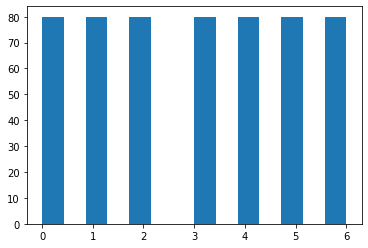

In [ ]:
plt.hist(y_classes, bins=14)

In [ ]:
#Splitting unnormalized data
X_train_unnorm, y_train = X[:int(0.8*train_len)].reshape(-1,IMG_SIZE,IMG_SIZE,3), y[:int(0.8*train_len)]
X_val_unnorm, y_val = X[int(0.8*train_len):].reshape(-1,IMG_SIZE,IMG_SIZE,3), y[int(0.8*train_len):]
X_test_unnorm = np.array([i[1] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [ ]:
#Compute mean and std 
X_train_mean = np.mean(np.mean(X_train_unnorm, axis=0), axis=(0,1))
X_train_dev = np.std(X_train_unnorm, axis=(0,1,2))
#Normalizing data
X_train_norm = (X_train_unnorm-X_train_mean)/X_train_dev
X_val_norm = (X_val_unnorm-X_train_mean)/X_train_dev
X_test_norm = (X_test_unnorm-X_train_mean)/X_train_dev

array([84.32553866, 92.67003838, 89.00964827])

In [ ]:
#create augmented data generator
train_datagen = ImageDataGenerator(rotation_range=90,
                            rescale=1,
                            zoom_range=[0.4,1.5],
                            width_shift_range = 0.3,
                            height_shift_range = 0.3,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_it = train_datagen.flow(X_train_norm, y_train)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2

In [ ]:
def net():
    model = Sequential()

    model.add(Conv2D(16, (3,3), padding='same', input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(LeakyReLU(0.1))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(0.1))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Dropout(0.25))
    model.add(LeakyReLU(0.1))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [ ]:
tf.keras.backend.clear_session()
net1 = net()
net1.summary()

In [ ]:
INIT_LR = 1e-2  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 75

opt = keras.optimizers.SGD(
    learning_rate=INIT_LR, momentum=0.9, nesterov=False, name="SGD",
)
net1.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

def lr_scheduler(epoch):
    return INIT_LR * 0.95 ** epoch

class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(net1.optimizer.lr))

In [ ]:
# fit model
history = net1.fit(
    train_it,  # augmented data generator
    batch_size=BATCH_SIZE,
    epochs=300,
    callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_val_norm, y_val)
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
with open('180070052.csv','w') as f:
    f.write('ImageID,Label\n')
            
with open('180070052.csv','a') as f:
    for data in tqdm(test_data):
        img_id = data[0]
        img_data = np.array(data[1])
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,3)
        data_norm = (np.array([data])-X_train_mean)/X_train_dev
        output = net1.predict(data_norm)[0]
        pred_class = np.argmax(output)+1
        f.write('{},{}\n'.format(img_id, pred_class))

100%|██████████| 95/95 [00:02<00:00, 31.90it/s]


In [ ]:
preds_test = net1.predict(X_test_norm)
preds_val = net1.predict(X_val_norm)
preds_train = net1.predict(X_train_norm)

In [ ]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, X_train_unnorm.shape[0])
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train_unnorm[random_index, :])
        str_label = str(classes[np.argmax(preds_train[random_index])])
        plt.title(str_label)
plt.show()

In [ ]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, X_val_unnorm.shape[0])
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_val_unnorm[random_index, :])
        str_label = str(classes[np.argmax(preds_val[random_index])])
        plt.title(str_label)
plt.show()

In [ ]:
cols = 5
rows = 16
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, X_test_unnorm.shape[0])
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_test_unnorm[rows*i+j, :])
        str_label = str(classes[np.argmax(preds_test[rows*i+j])])
        plt.title(str_label)
plt.show()